In [1]:
import random
import math
import numpy as np
import matplotlib.pyplot as plt 
import numba as nb
%matplotlib inline

def mat_to_color(mat):
    colors = np.array(((66, 66, 111), (244, 164, 96)))
    index = np.digitize(mat.ravel(), [0,1], right=True)
    return colors[index].reshape(mat.shape + (3,)).astype(np.uint8)

def plot_color(mat):
    fig, ax = plt.subplots()
    h = ax.imshow(mat_to_color(mat))
    plt.show()
    
def point_to_image_mat(mat, img_size=(500,500)):
    mat = np.array(mat).T
    x_max, x_min = mat[0].max(), mat[0].min()
    y_max, y_min = mat[1].max(), mat[1].min()
    x_rng, y_rng = x_max - x_min, y_max - y_min
    mul_factor_x = (img_size[0]-1)/x_rng
    mul_factor_y = (img_size[1]-1)/y_rng
    img = np.zeros(img_size)
    for x, y in mat.T:
        img[int((x - x_min)*mul_factor_x),int((y - y_min)*mul_factor_y)] = 1
    return img

def plot_points(mat, img_size=(500,500)):
    plot_color(point_to_image_mat(mat, img_size))

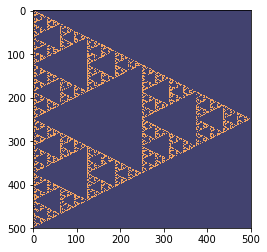

115 ms ± 11.3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [7]:
def instantiate_points(point_count):
    # Creates points on a unit circle of count pointCount
    # The radius of this circle is 1
    points = []
    for i in range(point_count):
        const = 2 * math.pi * i / point_count
        x, y = math.sin(const), math.cos(const)
        points.append([x,y])

    return points

def choices(conditionArray):
    pointCount = len(conditionArray)
    choice = random.randint(0, pointCount - 1)
    
    while True:
        for _ in range(100):
            # Loop until we find an index that has a true value in conditionArray
            potential_choice = random.randint(0, pointCount - 1)
            idx = (potential_choice - choice) % pointCount
            if not conditionArray[idx]:
                choice = potential_choice
                yield choice

def create_point(point, edge_point, scaling_factor=2):
    x, y = point
    _x, _y = edge_point
    return ((x + _x)/scaling_factor, (y + _y)/scaling_factor)

def fractal(iters=50000, dry_fire=1000, point_count=3, 
            scaling_factor=2, selection_limiter=None):
    
    if selection_limiter is None:
        selection_limiter = [False]*point_count        
        
    point = [random.uniform(-1,1), random.uniform(-1,1)]
    
    choice_gen = choices(selection_limiter)
    points_array = instantiate_points(point_count)
    choice = None
    mat = list(points_array)
    
    for i in range(iters):
        choice = next(choice_gen)
        point = create_point(point, points_array[choice], 
                             scaling_factor=scaling_factor)
        if i > dry_fire:
            mat.append(point)
    
    return mat

plot_points(fractal())
%timeit fractal()

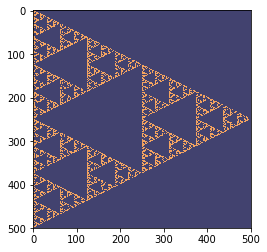

2.81 ms ± 131 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [6]:
@nb.jit(nopython=True)
def instantiate_points(point_count):
    # Creates points on a unit circle of count pointCount
    # The radius of this circle is 1
    points = np.zeros((point_count,2))
    for i in range(point_count):
        const = 2 * math.pi * i / point_count
        x, y = math.sin(const), math.cos(const)
        points[i] = [x,y]

    return points

@nb.jit(nopython=True)
def choices(conditionArray):
    pointCount = len(conditionArray)
    choice = random.randint(0, pointCount - 1)
    
    while True:
        for _ in range(100):
            # Loop until we find an index that has a true value in conditionArray
            potential_choice = random.randint(0, pointCount - 1)
            idx = (potential_choice - choice) % pointCount
            if not conditionArray[idx]:
                choice = potential_choice
                yield choice

@nb.jit(nopython=True)
def create_point(point, edge_point, scaling_factor=2):
    x, y = point
    _x, _y = edge_point
    return ((x + _x)/scaling_factor, (y + _y)/scaling_factor)

@nb.jit(nopython=True)
def fractal_loop(selection_limiter, scaling_factor, iters, dry_fire, point_count):
    gen_choice = choices(selection_limiter)
    point = (random.uniform(-1,1), random.uniform(-1,1))
    points_array = instantiate_points(point_count)
    mat = np.zeros((point_count + iters - dry_fire, 2))
    for i in range(iters):
        choice = next(gen_choice)
        point = create_point(point, points_array[choice], 
                             scaling_factor=scaling_factor)
        if i > dry_fire:
            mat[i-dry_fire] = point
    return mat    

def fractal(iters=50000, dry_fire=1000, point_count=3, 
            scaling_factor=2, selection_limiter=None):
    
    if selection_limiter is None:
        selection_limiter = [False]*point_count
    
    return fractal_loop(selection_limiter, scaling_factor, iters, dry_fire, point_count)

plot_points(fractal())
%timeit fractal()